In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import line_search
from functools import reduce
from collections import defaultdict
from scipy.stats import multivariate_normal
from sklearn import metrics

h = 0.001

# SVM

In [2]:
from scipy.optimize import minimize

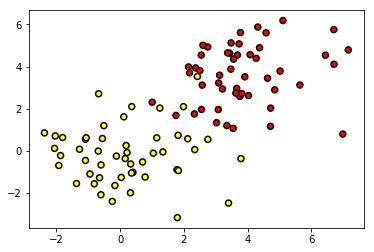

In [3]:
#generate data: two classes that contain groups of normal distributed values
class_size_1 = 50
class_size_2 = 50

mean_1 = 0.0
mean_2 = 4.0

std_1 = 1.5
std_2 = 1.5

train_data = np.random.normal(size=(class_size_1, 2), loc=mean_1, scale=std_1)
train_labels = np.ones(class_size_1)

train_data = np.concatenate((train_data, np.random.normal(size=(class_size_2, 2), loc=mean_2, scale=std_2)))
train_labels = np.concatenate((train_labels, -np.ones(class_size_2)))

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

In [4]:
def linear_kernel(left, right):
    return np.dot(left, right)

def polinomial_kernel(left, right, dim=2):
    return (1 + np.dot(left, right))**dim

def cost_function_compute(train_data, train_labels, kernel):
    def cost_function(params):        
        temporary1 = np.outer(params, params)
        temporary2 = np.outer(train_labels, train_labels)
        temporary3 = np.array([[kernel(x_i, x_j) for x_j in train_data] for x_i in train_data])
        result = np.sum(params) - 0.5*np.sum(temporary1*temporary2*temporary3)
        return -result
    return cost_function

def svm(train_data, train_labels, kernel=linear_kernel):
    cost_func = cost_function_compute(train_data, train_labels, kernel)
    constraint = 0.5/(2*len(train_labels))

    cons = []
    bounds = []
    for i in range(len(train_labels)):
        bounds.append((0, constraint))
    cons.append({'type': 'eq', 'fun': lambda x: np.dot(x, train_labels)})
    bounds = tuple(bounds)
    cons = tuple(cons)
    res = minimize(cost_func, x0=np.zeros(len(train_labels)), method='SLSQP', constraints=cons, bounds=bounds)
    
    if kernel==polinomial_kernel:
        #gram_matrix = np.array([[kernel(x_i, x_j) for x_j in train_data] for x_i in train_data])
        #U, D, U_t = np.linalg.svd(gram_matrix)

        #D = np.sqrt(D)
        #D = np.take(D, np.where(D > 1e-3), axis=0)[0]
    
        #phi_values = np.array([D*u[:len(D)] for u in)
        phi_values = np.array([[1.0, sample[0]**2, np.sqrt(2)*sample[0]*sample[1], sample[1]**2, 
                               np.sqrt(2)*sample[0], np.sqrt(2)*sample[1]] for sample in train_data])
    
        indices = np.where(res.x != 0)
        coefficients = np.sum([param*label*sample 
                                        for param, label, sample 
                                        in zip(res.x, train_labels, phi_values)], 
                                        axis=0)
    
        intercept = np.mean([-np.dot(coefficients, phi_values[i]) + train_labels[i] for i in indices[0]])

    
    if kernel==linear_kernel:
        
        coefficients = np.sum([param*label*sample 
                                    for param, label, sample 
                                    in zip(res.x, train_labels, train_data)],
                                    axis=0) 
        indices = np.where(res.x != 0)
        
        support_vectors = np.take(train_data, indices, axis=0)[0]
        support_labels = np.take(train_labels, indices, axis=0)[0]
        
        intercept = np.mean([support_label - np.dot(coefficients, support_vector) 
                                    for support_label, support_vector 
                                    in zip(support_labels, support_vectors)])
    
    coefficients = np.insert(coefficients, 0, intercept)
    return coefficients, indices

In [5]:
parameters, indices = svm(train_data, train_labels, kernel=linear_kernel)
print(parameters)

[ 0.78078462 -0.21161495 -0.21743632]


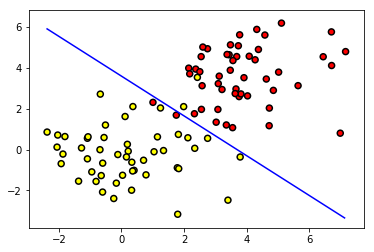

In [6]:
points_x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)

plt.plot(points_x, -parameters[0]/parameters[2]-points_x*parameters[1]/parameters[2], 'b')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5)

plt.show()

In [7]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(train_data, train_labels)
params = np.c_[clf.intercept_, clf.coef_][0]

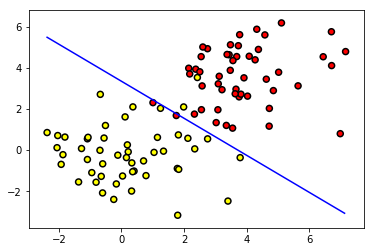

In [8]:
points_x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)

plt.plot(points_x, -params[0]/params[2]-points_x*params[1]/params[2], 'b')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5)
plt.show()

In [9]:
params, indices = svm(train_data, train_labels, kernel=polinomial_kernel)
print(params)

[  2.07241774e+00  -9.44270059e-15  -5.48966262e-02  -9.74941328e-02
  -4.41805610e-02  -2.88823744e-02  -3.67520379e-02]


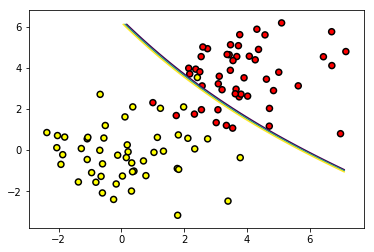

In [10]:
x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)
y = np.arange(np.min(train_data[:, 1]), np.max(train_data[:, 1]), 0.05)
X, Y = np.meshgrid(x, y)
Z = params[0] + params[1] + params[2]*X**2 + np.sqrt(2)*X*Y*params[3] + params[4]*Y**2 + np.sqrt(2)*X*params[5] + np.sqrt(2)*Y*params[6]

plt.contour(X, Y, Z, levels=[-0.05, 0.0, 0.05])
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5)
plt.show()

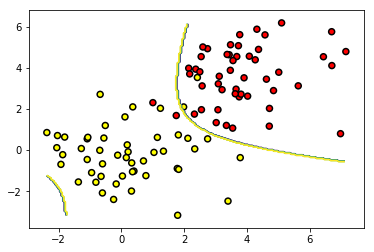

In [11]:
clf_poly = SVC(kernel='poly', degree=2)
clf_poly.fit(train_data, train_labels)

Z = clf_poly.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)
plt.contour(X, Y, Z)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5)
plt.show()

# Neural Network

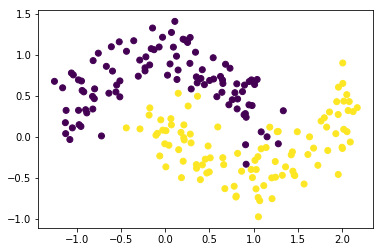

In [12]:
from sklearn import datasets
train_data, train_labels = datasets.make_moons(200, noise=0.20)
test_data, test_labels = datasets.make_moons(20, noise=0.20)
plt.scatter(train_data[:,0], train_data[:,1], c=train_labels)
plt.show()

In [13]:
num_examples = len(train_labels)
nn_input_dim = 2
nn_output_dim = 2
nn_hidden_layers = 20

epsilon = 0.01 
reg_lambda = 0.01 

In [14]:
W1 = np.random.normal(0.0, 0.05, (nn_input_dim, nn_hidden_layers))
b1 = np.random.normal(0.0, 0.05, (1, nn_hidden_layers))
W2 = np.random.normal(0.0, 0.05, (nn_hidden_layers, nn_output_dim))
b2 = np.random.normal(0.0, 0.05, (1, nn_output_dim))

## My model is two inputs, one hidden layer and two outputs. Activation function - tanh. Cost function - meaned cross-entropy with L2-regularization of weights.
### z1 = x*W1 + b1
### a1 = tanh(z1)
### z2 = a1*W2 + b2
### output = softmax(z2)

In [15]:
def loss(W1, b1, W2, b2, train_data, train_labels):
    #evaluation throught the layers
    z1 = train_data.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    #distribition
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    logprobs = -np.log(probs[range(num_examples), train_labels])
    data_loss = np.sum(corect_logprobs)
    #regulatization and compution loss 
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1.0/num_examples * data_loss

In [16]:
def predict(W1, b1, W2, b2, x):
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [17]:
#backprop
def train(W1, b1, W2, b2, train_data, train_labels, num_of_iter=10000):
    for i in range(0, num_of_iter):
        z1 = train_data.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        #will use chain rule
        delta_last = probs
        delta_last[range(num_examples), train_labels] -= 1
        
        db2 = np.sum(delta_last, axis=0, keepdims=True)
        delta_prev = delta_last.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(train_data.T, delta_prev)
        db1 = np.sum(delta_prev, axis=0)
 
        #regularization 
        dW2 = reg_lambda * W2
        dW1 = reg_lambda * W1

        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
    return W1, b1, W2, b2

In [18]:
W1, b1, W2, b2 = train(W1, b1, W2, b2, train_data, train_labels)

In [21]:
y_predicted = np.array([predict(W1, b1, W2, b2, sample) for sample in test_data])
metrics.accuracy_score(test_labels, y_predicted)

0.75